In [1]:
import pandas as pd
from sqlalchemy import create_engine, text
import geopandas as gpd

# Connect to your Postgres/PostGIS database
engine = create_engine('postgresql://markfinlay:@localhost:5432/osm_data')

# Define the list of OSM ids you want to process (adjust as needed)
osm_ids = [1088208454, 782378908, 315437490, 109066310, 1324047897, 816978050, 34325377, 136198332, 178167773, 40447316]  # Example OSM ids

# Update the query to select multiple trails using an IN clause
query = f"""
    SELECT osm_id, name, highway, surface, surface_group, way, ST_Length(way) AS length_m
    FROM planet_osm_line
    WHERE osm_id IN ({','.join(map(str, osm_ids))})
    """

# Read the trails as a GeoDataFrame (OSM data is in EPSG:3857)
gdf = gpd.read_postgis(query, engine, geom_col='way')

# (Re)create the table to store segment metadata and image data
with engine.begin() as conn:
    conn.execute(text("DROP TABLE IF EXISTS trail_segments;"))
    conn.execute(text("""
        CREATE TABLE trail_segment_metadata (
            id SERIAL PRIMARY KEY,
            filename TEXT,
            osm_id BIGINT,
            surface_group TEXT,
            center_geom geometry(Point,3857),
            image_data BYTEA
        );
    """))

print(f"Data loaded and database table set up. Row count: {len(gdf)}")


Data loaded and database table set up. Row count: 10


OSM id 34325377: Number of segments = 4, Length = 1236.72 m, Link: https://www.openstreetmap.org/way/34325377


/Users/markfinlay/code/myenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


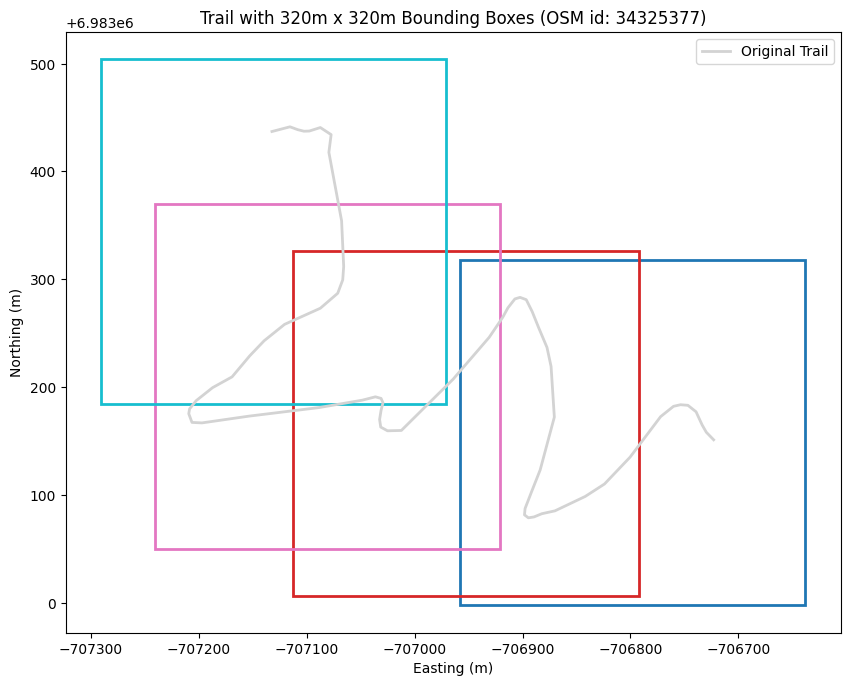

OSM id 40447316: Number of segments = 9, Length = 2877.85 m, Link: https://www.openstreetmap.org/way/40447316


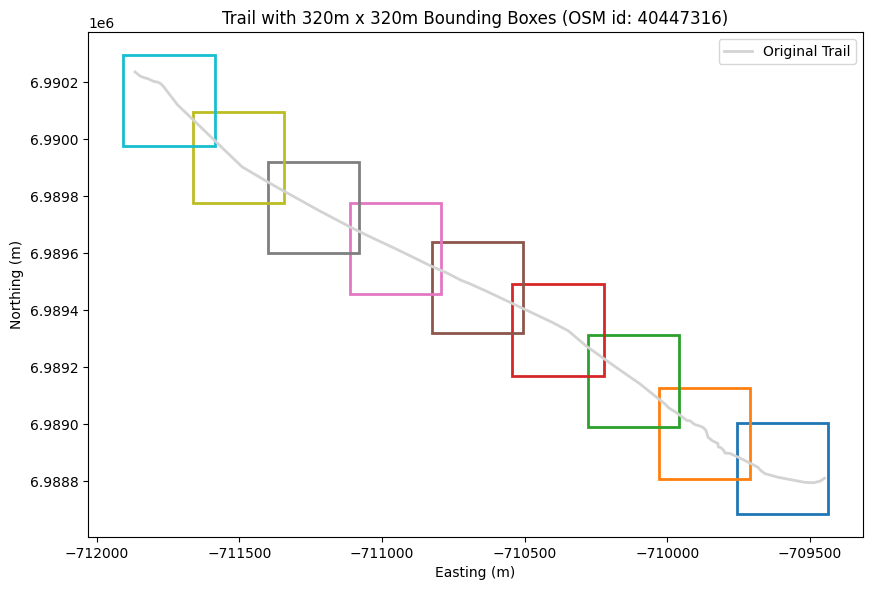

OSM id 109066310: Number of segments = 3, Length = 859.64 m, Link: https://www.openstreetmap.org/way/109066310


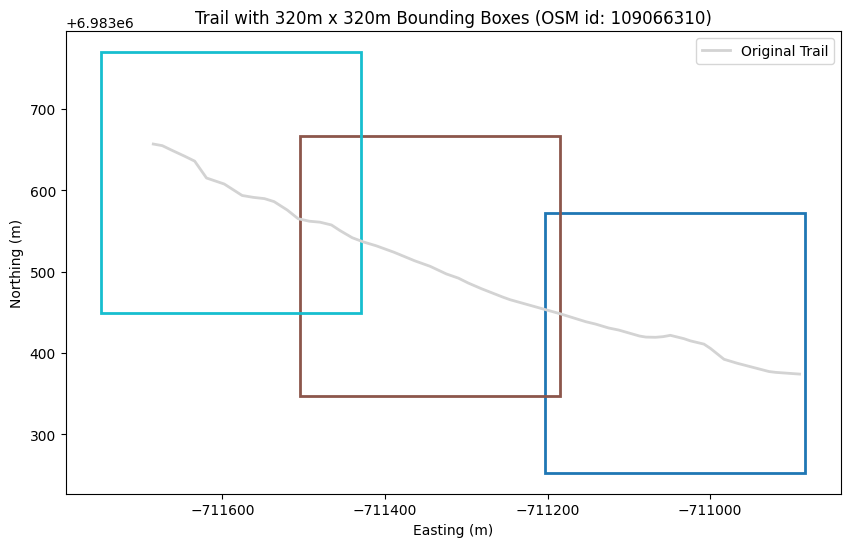

OSM id 136198332: Number of segments = 2, Length = 599.21 m, Link: https://www.openstreetmap.org/way/136198332


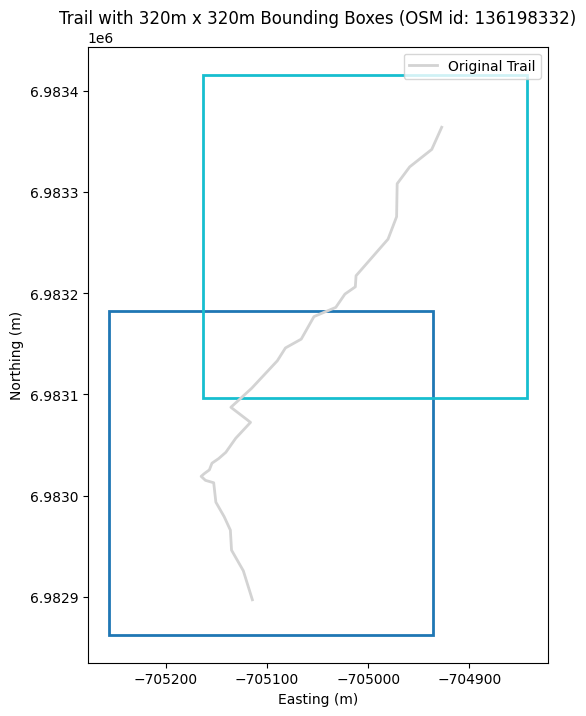

OSM id 178167773: Number of segments = 2, Length = 572.61 m, Link: https://www.openstreetmap.org/way/178167773


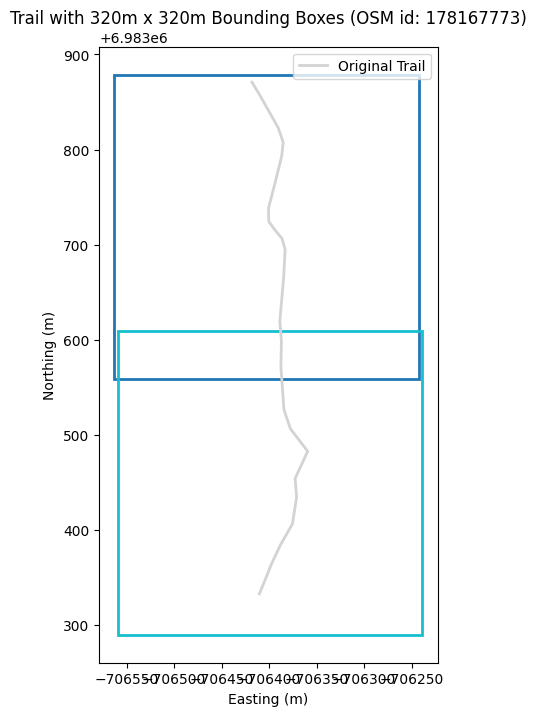

OSM id 315437490: Number of segments = 20, Length = 6323.89 m, Link: https://www.openstreetmap.org/way/315437490


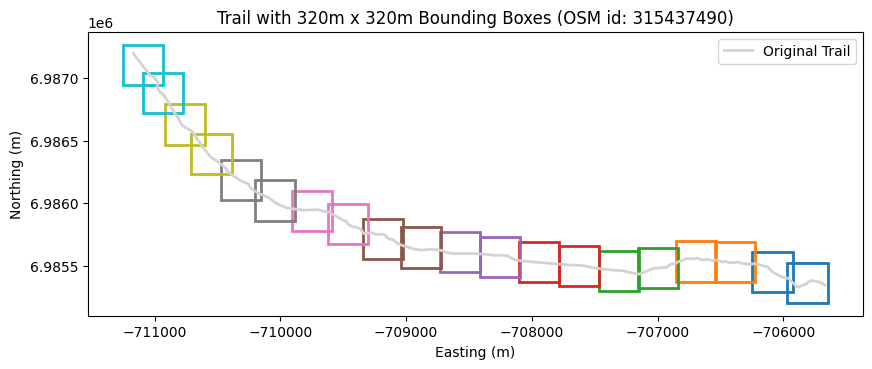

OSM id 782378908: Number of segments = 8, Length = 2457.96 m, Link: https://www.openstreetmap.org/way/782378908


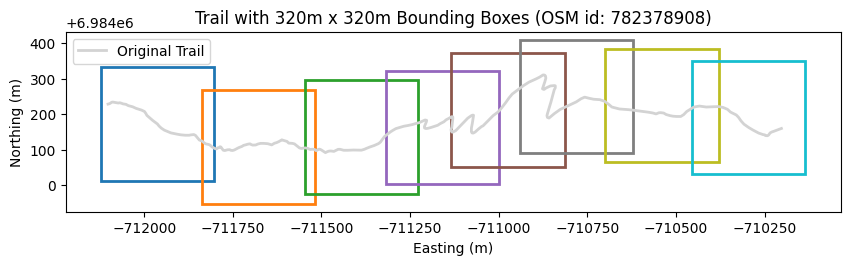

OSM id 816978050: Number of segments = 6, Length = 1609.43 m, Link: https://www.openstreetmap.org/way/816978050


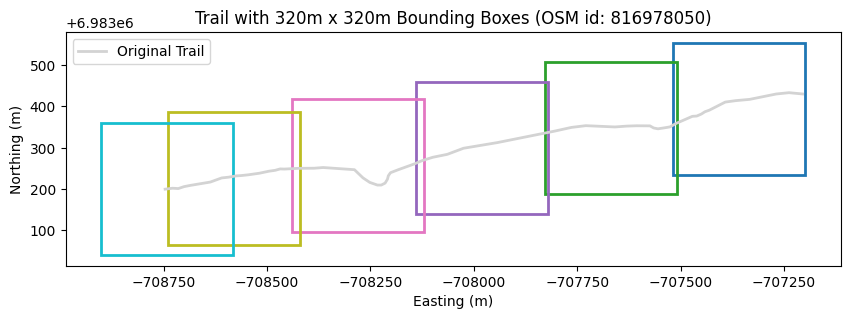

OSM id 1088208454: Number of segments = 5, Length = 1508.34 m, Link: https://www.openstreetmap.org/way/1088208454


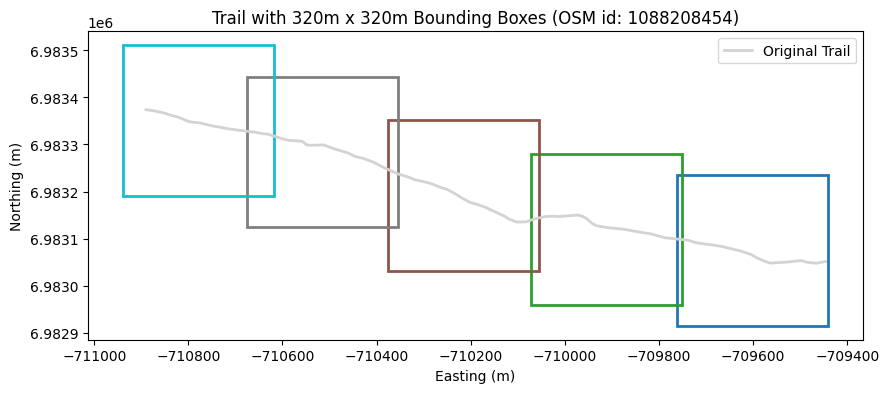

OSM id 1324047897: Number of segments = 2, Length = 392.00 m, Link: https://www.openstreetmap.org/way/1324047897


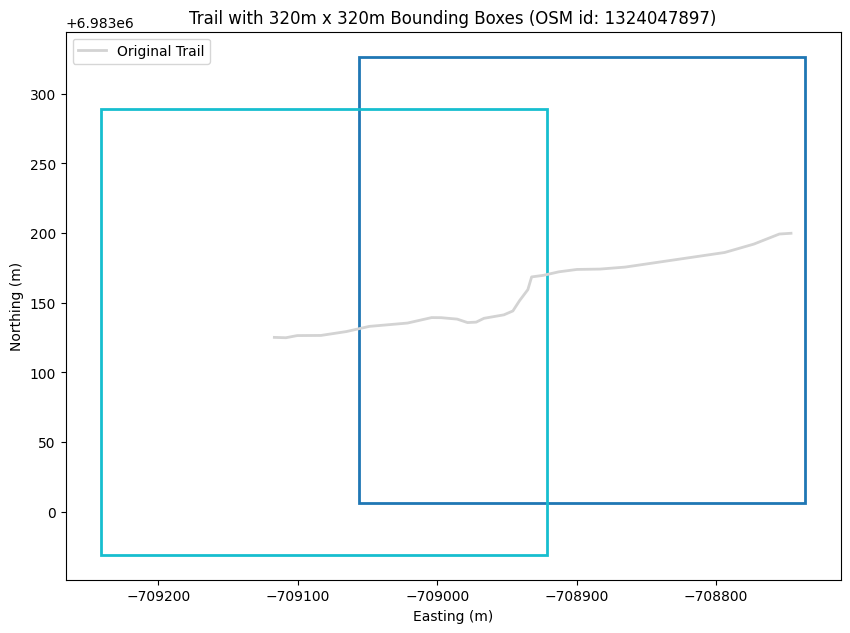

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from shapely.geometry import LineString
import geopandas as gpd
from sentinelhub import CRS, BBox

# Set parameters for segmentation and fixed bounding box dimensions (in meters)
segment_length = 320  # for segmenting the trail
fixed_width = 320     # bounding box width
fixed_height = 320    # bounding box height
half_width = fixed_width / 2
half_height = fixed_height / 2

# Process each trail from the GeoDataFrame
for idx_row, trail_row in gdf.iterrows():
    osm_id = trail_row['osm_id']
    trail_metric = trail_row['way']  # geometry in EPSG:3857
    
    # --- Segment the Trail ---
    num_segments = int(trail_metric.length // segment_length)
    segments = []
    for i in range(num_segments):
        start = trail_metric.interpolate(i * segment_length)
        end = trail_metric.interpolate((i + 1) * segment_length)
        segments.append(LineString([start, end]))
    # Add remaining piece if necessary
    if trail_metric.length % segment_length > 0:
        segments.append(LineString([trail_metric.interpolate(num_segments * segment_length),
                                     trail_metric.coords[-1]]))
    print(f"OSM id {osm_id}: Number of segments = {len(segments)}, Length = {trail_row['length_m']:.2f} m, Link: https://www.openstreetmap.org/way/{osm_id}")
    
    # --- Create Fixed-Size Bounding Boxes for Each Segment ---
    segment_bboxes = []
    for seg in segments:
        center = seg.centroid  # in EPSG:3857
        minx = center.x - half_width
        maxx = center.x + half_width
        miny = center.y - half_height
        maxy = center.y + half_height
        bbox_metric = BBox(bbox=[minx, miny, maxx, maxy], crs=CRS("EPSG:3857"))
        segment_bboxes.append(bbox_metric)
    
    # --- Visualization ---
    fig, ax = plt.subplots(figsize=(10, 8))
    # Plot the original trail in light gray
    x, y = trail_metric.xy
    ax.plot(x, y, color='lightgray', linewidth=2, label='Original Trail')
    # Color each segment differently
    colors = plt.cm.tab10(np.linspace(0, 1, len(segments)))
    # Draw each bounding box
    for idx, bbox in enumerate(segment_bboxes):
        width = bbox.max_x - bbox.min_x
        height = bbox.max_y - bbox.min_y
        rect = patches.Rectangle((bbox.min_x, bbox.min_y), width, height,
                                 facecolor='none', edgecolor=colors[idx], linewidth=2)
        ax.add_patch(rect)
    
    ax.set_aspect('equal', 'box')
    ax.set_xlabel("Easting (m)")
    ax.set_ylabel("Northing (m)")
    ax.set_title(f"Trail with 320m x 320m Bounding Boxes (OSM id: {osm_id})")
    ax.legend()
    plt.show()


In [3]:
import io
from PIL import Image, ImageDraw
from sqlalchemy import text
from sentinelhub import SentinelHubRequest, DataCollection, MimeType, CRS, bbox_to_dimensions, SHConfig
import numpy as np

# Sentinel Hub configuration (assumed already set up)
config = SHConfig()
config.sh_client_id = 'f3101a77-1835-4be3-ae45-7e9f7c5ff738'
config.sh_client_secret = 'qTPPEOHdlEQdUUDcFZaYGFBpgYii1CWI'

evalscript = """
//VERSION=3
function setup() {
  return {
    input: ["B02", "B03", "B04"],
    output: { bands: 3 }
  };
}
function evaluatePixel(sample) {
  var factor = 8;  // Increase brightness
  return [
    Math.min(sample.B04 * factor, 1.0),
    Math.min(sample.B03 * factor, 1.0),
    Math.min(sample.B02 * factor, 1.0)
  ];
}
"""

# SQL insert statement
insert_sql = """
INSERT INTO trail_segment_metadata (filename, osm_id, surface_group, center_geom, image_data)
VALUES (:filename, :osm_id, :surface_group, ST_SetSRID(ST_MakePoint(:center_lon, :center_lat), 3857), :image_data);
"""

# Loop over each trail to process Sentinel‑2 requests (this is inside your loop over trails)
for idx_row, trail_row in gdf.iterrows():
    osm_id = trail_row['osm_id']
    surface_group = trail_row['surface_group']
    trail_metric = trail_row['way']
    
    # Segment the trail as before
    num_segments = int(trail_metric.length // segment_length)
    segments = []
    for i in range(num_segments):
        start = trail_metric.interpolate(i * segment_length)
        end = trail_metric.interpolate((i + 1) * segment_length)
        segments.append(LineString([start, end]))
    if trail_metric.length % segment_length > 0:
        segments.append(LineString([trail_metric.interpolate(num_segments * segment_length),
                                     trail_metric.coords[-1]]))
    
    # Create bounding boxes for each segment
    segment_bboxes = []
    for seg in segments:
        center = seg.centroid
        minx = center.x - half_width
        maxx = center.x + half_width
        miny = center.y - half_height
        maxy = center.y + half_height
        bbox_metric = BBox(bbox=[minx, miny, maxx, maxy], crs=CRS("EPSG:3857"))
        segment_bboxes.append(bbox_metric)
    
    # Process each segment
    for idx_seg, seg in enumerate(segments):
        # Use the precomputed bounding box (in EPSG:3857)
        new_bbox_metric = segment_bboxes[idx_seg]
        seg_bbox = new_bbox_metric
        center_lon = (seg_bbox.min_x + seg_bbox.max_x) / 2
        center_lat = (seg_bbox.min_y + seg_bbox.max_y) / 2
        
        resolution = 10  
        size = bbox_to_dimensions(seg_bbox, resolution=resolution)  # should yield (32, 32)
        
        request = SentinelHubRequest(
            data_folder=f'sentinel_data_segments/{osm_id}',
            evalscript=evalscript,
            input_data=[
                SentinelHubRequest.input_data(
                    data_collection=DataCollection.SENTINEL2_L2A,
                    time_interval=('2025-01-01', '2025-03-20'),
                    mosaicking_order='leastCC'
                )
            ],
            responses=[SentinelHubRequest.output_response('default', MimeType.TIFF)],
            bbox=seg_bbox,
            size=size,
            config=config
        )
        
        seg_image = request.get_data(save_data=True)[0]
        # Transpose image if needed
        if seg_image.ndim == 3 and seg_image.shape[0] == 3:
            seg_image_disp = seg_image.transpose(1, 2, 0)
        else:
            seg_image_disp = seg_image
        # Convert to uint8 if necessary
        if seg_image_disp.dtype != np.uint8:
            seg_image_disp_uint8 = (np.clip(seg_image_disp, 0, 1) * 255).astype(np.uint8)
        else:
            seg_image_disp_uint8 = seg_image_disp
        
        # Convert the unmasked image to a PNG byte stream
        im = Image.fromarray(seg_image_disp_uint8)
        buffer = io.BytesIO()
        im.save(buffer, format="PNG")
        image_bytes = buffer.getvalue()
        
        
        
        # Construct a filename that includes the OSM id and segment index
        filename = f"{osm_id}_segment_{idx_seg+1}"
        
        metadata = {
            "filename": filename,
            "osm_id": int(osm_id),
            "surface_group": surface_group,
            "center_lon": center_lon,
            "center_lat": center_lat,
            "image_data": image_bytes
        }
        
        with engine.begin() as conn:
            conn.execute(text(insert_sql), metadata)
        print(f"OSM id {osm_id}: Processed {filename}")

print("Sentinel-2 data collection complete.")


OSM id 34325377: Processed 34325377_segment_1
OSM id 34325377: Processed 34325377_segment_2
OSM id 34325377: Processed 34325377_segment_3
OSM id 34325377: Processed 34325377_segment_4
OSM id 40447316: Processed 40447316_segment_1
OSM id 40447316: Processed 40447316_segment_2
OSM id 40447316: Processed 40447316_segment_3
OSM id 40447316: Processed 40447316_segment_4
OSM id 40447316: Processed 40447316_segment_5
OSM id 40447316: Processed 40447316_segment_6
OSM id 40447316: Processed 40447316_segment_7
OSM id 40447316: Processed 40447316_segment_8
OSM id 40447316: Processed 40447316_segment_9
OSM id 109066310: Processed 109066310_segment_1
OSM id 109066310: Processed 109066310_segment_2
OSM id 109066310: Processed 109066310_segment_3
OSM id 136198332: Processed 136198332_segment_1
OSM id 136198332: Processed 136198332_segment_2
OSM id 178167773: Processed 178167773_segment_1
OSM id 178167773: Processed 178167773_segment_2
OSM id 315437490: Processed 315437490_segment_1
OSM id 315437490: 

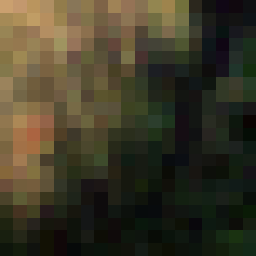

Filename: 34325377_segment_1
OSM ID: 34325377
Surface Group: gravel
Center Lat: 6983157.687250499
Center Lon: -706797.7738276143
OpenStreetMap Link: https://www.openstreetmap.org/way/34325377
--------------------------------------------------------------------------------


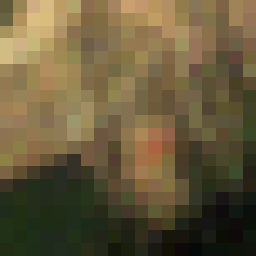

Filename: 34325377_segment_2
OSM ID: 34325377
Surface Group: gravel
Center Lat: 6983166.280474923
Center Lon: -706952.4825974917
OpenStreetMap Link: https://www.openstreetmap.org/way/34325377
--------------------------------------------------------------------------------


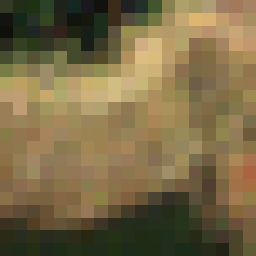

Filename: 34325377_segment_3
OSM ID: 34325377
Surface Group: gravel
Center Lat: 6983209.7551887315
Center Lon: -707080.8647672345
OpenStreetMap Link: https://www.openstreetmap.org/way/34325377
--------------------------------------------------------------------------------


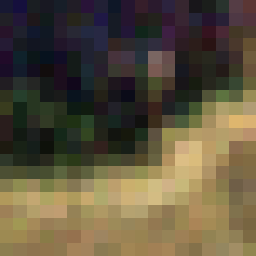

Filename: 34325377_segment_4
OSM ID: 34325377
Surface Group: gravel
Center Lat: 6983344.049606502
Center Lon: -707130.8892388495
OpenStreetMap Link: https://www.openstreetmap.org/way/34325377
--------------------------------------------------------------------------------


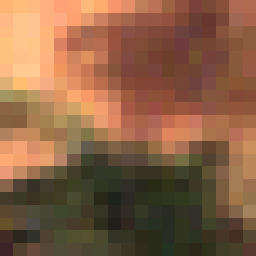

Filename: 40447316_segment_1
OSM ID: 40447316
Surface Group: mud/dirt
Center Lat: 6988846.643057488
Center Lon: -709597.1767742225
OpenStreetMap Link: https://www.openstreetmap.org/way/40447316
--------------------------------------------------------------------------------


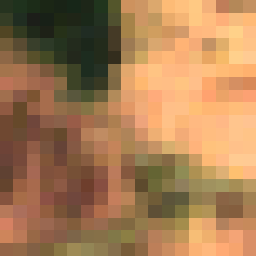

Filename: 40447316_segment_2
OSM ID: 40447316
Surface Group: mud/dirt
Center Lat: 6988969.107040315
Center Lon: -709868.6213323696
OpenStreetMap Link: https://www.openstreetmap.org/way/40447316
--------------------------------------------------------------------------------


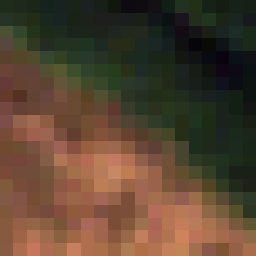

Filename: 40447316_segment_3
OSM ID: 40447316
Surface Group: mud/dirt
Center Lat: 6989152.280726763
Center Lon: -710119.6390557104
OpenStreetMap Link: https://www.openstreetmap.org/way/40447316
--------------------------------------------------------------------------------


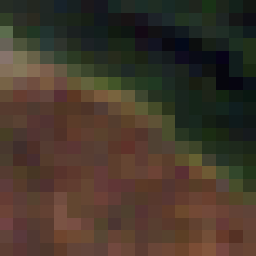

Filename: 40447316_segment_4
OSM ID: 40447316
Surface Group: mud/dirt
Center Lat: 6989330.612423215
Center Lon: -710383.3998842372
OpenStreetMap Link: https://www.openstreetmap.org/way/40447316
--------------------------------------------------------------------------------


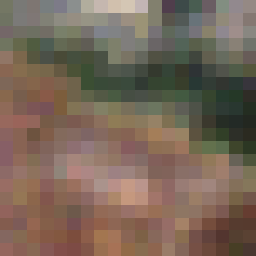

Filename: 40447316_segment_5
OSM ID: 40447316
Surface Group: mud/dirt
Center Lat: 6989480.012200679
Center Lon: -710664.664482658
OpenStreetMap Link: https://www.openstreetmap.org/way/40447316
--------------------------------------------------------------------------------


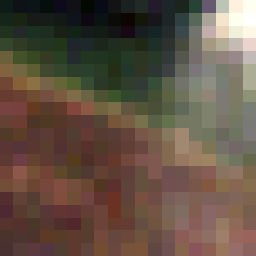

Filename: 40447316_segment_6
OSM ID: 40447316
Surface Group: mud/dirt
Center Lat: 6989616.293570854
Center Lon: -710954.1044934783
OpenStreetMap Link: https://www.openstreetmap.org/way/40447316
--------------------------------------------------------------------------------


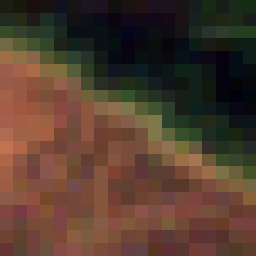

Filename: 40447316_segment_7
OSM ID: 40447316
Surface Group: mud/dirt
Center Lat: 6989761.605306604
Center Lon: -711239.0690697904
OpenStreetMap Link: https://www.openstreetmap.org/way/40447316
--------------------------------------------------------------------------------


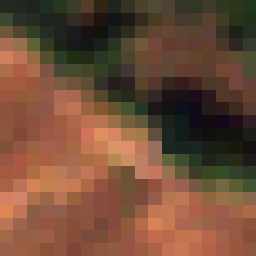

Filename: 40447316_segment_8
OSM ID: 40447316
Surface Group: mud/dirt
Center Lat: 6989936.66729991
Center Lon: -711504.1921992572
OpenStreetMap Link: https://www.openstreetmap.org/way/40447316
--------------------------------------------------------------------------------


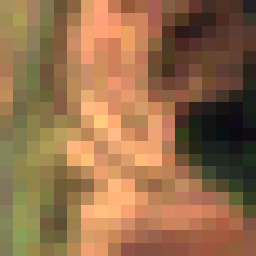

Filename: 40447316_segment_9
OSM ID: 40447316
Surface Group: mud/dirt
Center Lat: 6990135.651536112
Center Lon: -711747.3308389712
OpenStreetMap Link: https://www.openstreetmap.org/way/40447316
--------------------------------------------------------------------------------


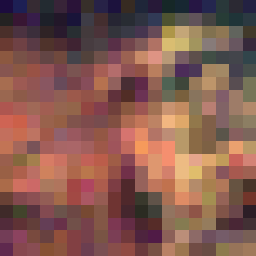

Filename: 109066310_segment_1
OSM ID: 109066310
Surface Group: wood
Center Lat: 6983412.54939965
Center Lon: -711042.6891181007
OpenStreetMap Link: https://www.openstreetmap.org/way/109066310
--------------------------------------------------------------------------------


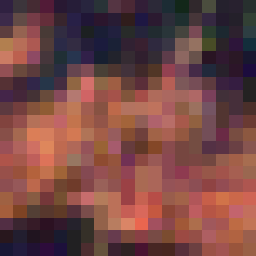

Filename: 109066310_segment_2
OSM ID: 109066310
Surface Group: wood
Center Lat: 6983506.699475595
Center Lon: -711344.7210915765
OpenStreetMap Link: https://www.openstreetmap.org/way/109066310
--------------------------------------------------------------------------------


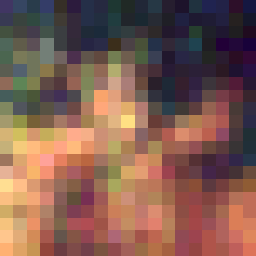

Filename: 109066310_segment_3
OSM ID: 109066310
Surface Group: wood
Center Lat: 6983609.559349283
Center Lon: -711589.4956241398
OpenStreetMap Link: https://www.openstreetmap.org/way/109066310
--------------------------------------------------------------------------------


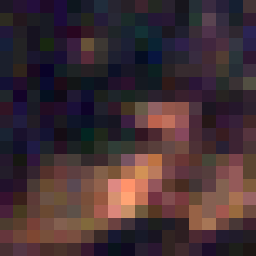

Filename: 136198332_segment_1
OSM ID: 136198332
Surface Group: gravel
Center Lat: 6983022.54539322
Center Lon: -705096.4338422304
OpenStreetMap Link: https://www.openstreetmap.org/way/136198332
--------------------------------------------------------------------------------


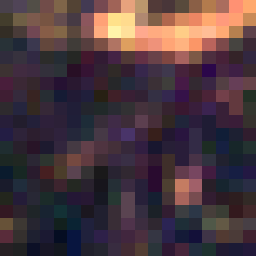

Filename: 136198332_segment_2
OSM ID: 136198332
Surface Group: gravel
Center Lat: 6983256.0591052035
Center Lon: -705002.8642442441
OpenStreetMap Link: https://www.openstreetmap.org/way/136198332
--------------------------------------------------------------------------------


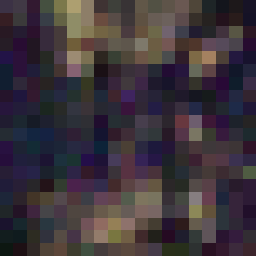

Filename: 178167773_segment_1
OSM ID: 178167773
Surface Group: gravel
Center Lat: 6983718.720330322
Center Lon: -706402.6450288435
OpenStreetMap Link: https://www.openstreetmap.org/way/178167773
--------------------------------------------------------------------------------


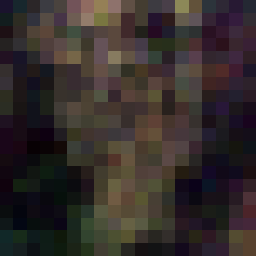

Filename: 178167773_segment_2
OSM ID: 178167773
Surface Group: gravel
Center Lat: 6983449.564361181
Center Lon: -706398.7321487421
OpenStreetMap Link: https://www.openstreetmap.org/way/178167773
--------------------------------------------------------------------------------


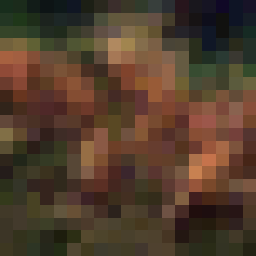

Filename: 315437490_segment_1
OSM ID: 315437490
Surface Group: grass
Center Lat: 6985369.75715505
Center Lon: -705808.2362602609
OpenStreetMap Link: https://www.openstreetmap.org/way/315437490
--------------------------------------------------------------------------------


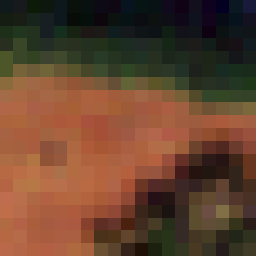

Filename: 315437490_segment_2
OSM ID: 315437490
Surface Group: grass
Center Lat: 6985454.898712143
Center Lon: -706087.7880680723
OpenStreetMap Link: https://www.openstreetmap.org/way/315437490
--------------------------------------------------------------------------------


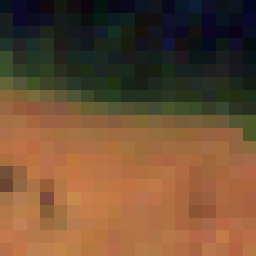

Filename: 315437490_segment_3
OSM ID: 315437490
Surface Group: grass
Center Lat: 6985534.316034707
Center Lon: -706385.581972122
OpenStreetMap Link: https://www.openstreetmap.org/way/315437490
--------------------------------------------------------------------------------


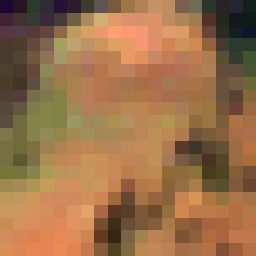

Filename: 315437490_segment_4
OSM ID: 315437490
Surface Group: grass
Center Lat: 6985539.154727531
Center Lon: -706695.2593649992
OpenStreetMap Link: https://www.openstreetmap.org/way/315437490
--------------------------------------------------------------------------------


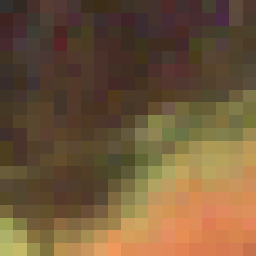

Filename: 315437490_segment_5
OSM ID: 315437490
Surface Group: grass
Center Lat: 6985484.066159618
Center Lon: -706998.8430442433
OpenStreetMap Link: https://www.openstreetmap.org/way/315437490
--------------------------------------------------------------------------------


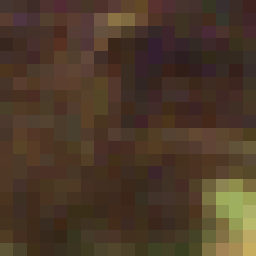

Filename: 315437490_segment_6
OSM ID: 315437490
Surface Group: grass
Center Lat: 6985460.687312274
Center Lon: -707306.7104157823
OpenStreetMap Link: https://www.openstreetmap.org/way/315437490
--------------------------------------------------------------------------------


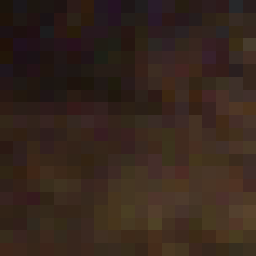

Filename: 315437490_segment_7
OSM ID: 315437490
Surface Group: grass
Center Lat: 6985499.830030433
Center Lon: -707623.3839421623
OpenStreetMap Link: https://www.openstreetmap.org/way/315437490
--------------------------------------------------------------------------------


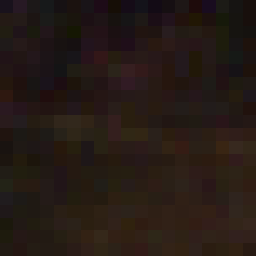

Filename: 315437490_segment_8
OSM ID: 315437490
Surface Group: grass
Center Lat: 6985531.641241184
Center Lon: -707941.3379612135
OpenStreetMap Link: https://www.openstreetmap.org/way/315437490
--------------------------------------------------------------------------------


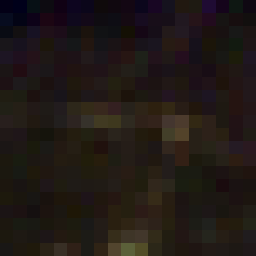

Filename: 315437490_segment_9
OSM ID: 315437490
Surface Group: grass
Center Lat: 6985572.3267457895
Center Lon: -708255.7550747083
OpenStreetMap Link: https://www.openstreetmap.org/way/315437490
--------------------------------------------------------------------------------


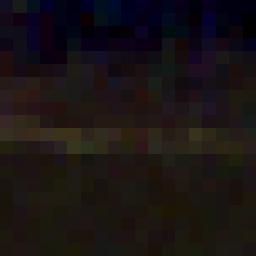

Filename: 315437490_segment_10
OSM ID: 315437490
Surface Group: grass
Center Lat: 6985612.953470435
Center Lon: -708568.7807719876
OpenStreetMap Link: https://www.openstreetmap.org/way/315437490
--------------------------------------------------------------------------------


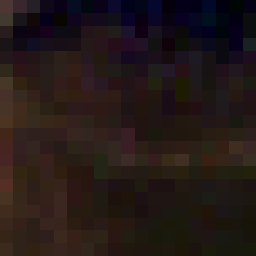

Filename: 315437490_segment_11
OSM ID: 315437490
Surface Group: grass
Center Lat: 6985648.662216864
Center Lon: -708883.374295048
OpenStreetMap Link: https://www.openstreetmap.org/way/315437490
--------------------------------------------------------------------------------


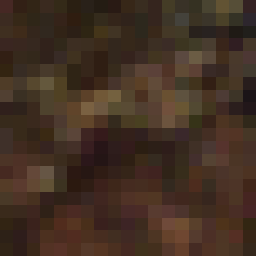

Filename: 315437490_segment_12
OSM ID: 315437490
Surface Group: grass
Center Lat: 6985714.874415337
Center Lon: -709183.5866981272
OpenStreetMap Link: https://www.openstreetmap.org/way/315437490
--------------------------------------------------------------------------------


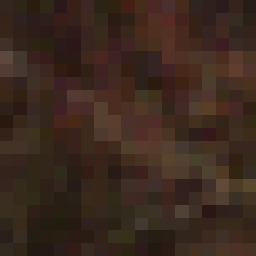

Filename: 315437490_segment_13
OSM ID: 315437490
Surface Group: grass
Center Lat: 6985838.544607
Center Lon: -709459.441709958
OpenStreetMap Link: https://www.openstreetmap.org/way/315437490
--------------------------------------------------------------------------------


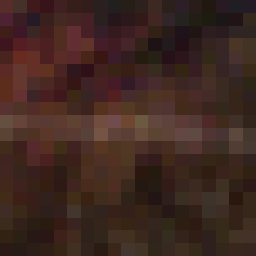

Filename: 315437490_segment_14
OSM ID: 315437490
Surface Group: grass
Center Lat: 6985937.735245398
Center Lon: -709746.687994059
OpenStreetMap Link: https://www.openstreetmap.org/way/315437490
--------------------------------------------------------------------------------


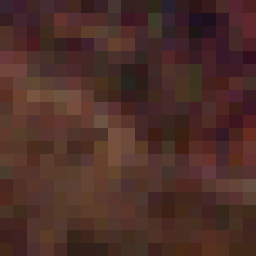

Filename: 315437490_segment_15
OSM ID: 315437490
Surface Group: grass
Center Lat: 6986023.989489453
Center Lon: -710045.3560775818
OpenStreetMap Link: https://www.openstreetmap.org/way/315437490
--------------------------------------------------------------------------------


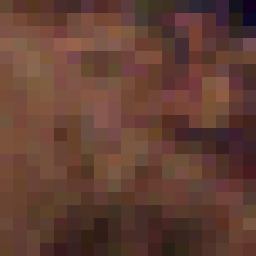

Filename: 315437490_segment_16
OSM ID: 315437490
Surface Group: grass
Center Lat: 6986185.754635865
Center Lon: -710312.8259321167
OpenStreetMap Link: https://www.openstreetmap.org/way/315437490
--------------------------------------------------------------------------------


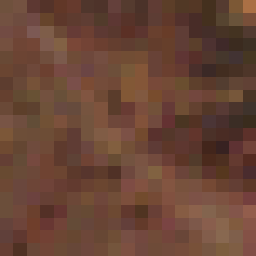

Filename: 315437490_segment_17
OSM ID: 315437490
Surface Group: grass
Center Lat: 6986394.385947087
Center Lon: -710547.1314385745
OpenStreetMap Link: https://www.openstreetmap.org/way/315437490
--------------------------------------------------------------------------------


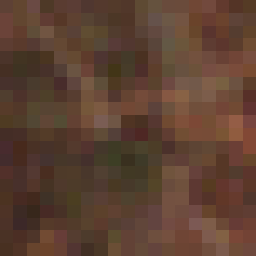

Filename: 315437490_segment_18
OSM ID: 315437490
Surface Group: grass
Center Lat: 6986627.137476744
Center Lon: -710757.6177276649
OpenStreetMap Link: https://www.openstreetmap.org/way/315437490
--------------------------------------------------------------------------------


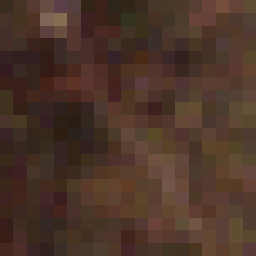

Filename: 315437490_segment_19
OSM ID: 315437490
Surface Group: grass
Center Lat: 6986879.440094805
Center Lon: -710934.7607152949
OpenStreetMap Link: https://www.openstreetmap.org/way/315437490
--------------------------------------------------------------------------------


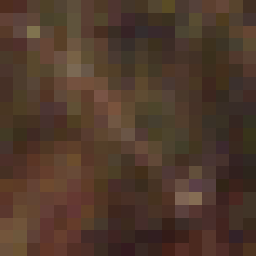

Filename: 315437490_segment_20
OSM ID: 315437490
Surface Group: grass
Center Lat: 6987102.042576093
Center Lon: -711090.1541397581
OpenStreetMap Link: https://www.openstreetmap.org/way/315437490
--------------------------------------------------------------------------------


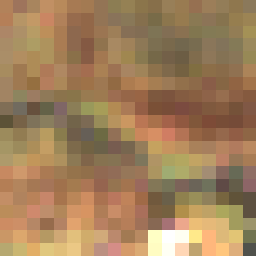

Filename: 782378908_segment_1
OSM ID: 782378908
Surface Group: mud/dirt
Center Lat: 6984171.971259516
Center Lon: -711962.1821319112
OpenStreetMap Link: https://www.openstreetmap.org/way/782378908
--------------------------------------------------------------------------------


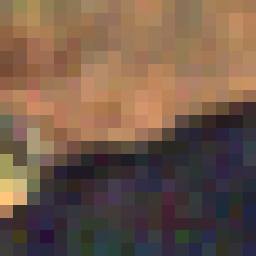

Filename: 782378908_segment_2
OSM ID: 782378908
Surface Group: mud/dirt
Center Lat: 6984108.009824237
Center Lon: -711676.9978650294
OpenStreetMap Link: https://www.openstreetmap.org/way/782378908
--------------------------------------------------------------------------------


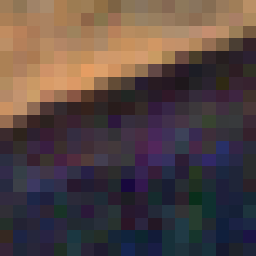

Filename: 782378908_segment_3
OSM ID: 782378908
Surface Group: mud/dirt
Center Lat: 6984136.067925863
Center Lon: -711386.3904011797
OpenStreetMap Link: https://www.openstreetmap.org/way/782378908
--------------------------------------------------------------------------------


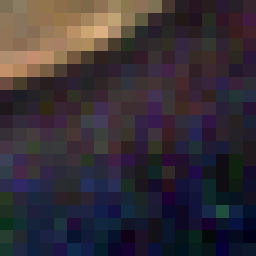

Filename: 782378908_segment_4
OSM ID: 782378908
Surface Group: mud/dirt
Center Lat: 6984162.146222303
Center Lon: -711159.1487880419
OpenStreetMap Link: https://www.openstreetmap.org/way/782378908
--------------------------------------------------------------------------------


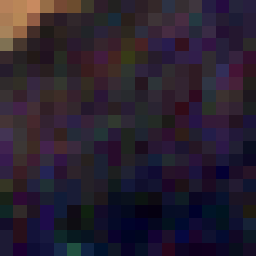

Filename: 782378908_segment_5
OSM ID: 782378908
Surface Group: mud/dirt
Center Lat: 6984211.452212648
Center Lon: -710974.4877515379
OpenStreetMap Link: https://www.openstreetmap.org/way/782378908
--------------------------------------------------------------------------------


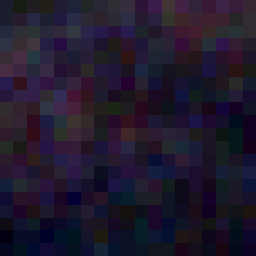

Filename: 782378908_segment_6
OSM ID: 782378908
Surface Group: mud/dirt
Center Lat: 6984249.304728051
Center Lon: -710781.3116597934
OpenStreetMap Link: https://www.openstreetmap.org/way/782378908
--------------------------------------------------------------------------------


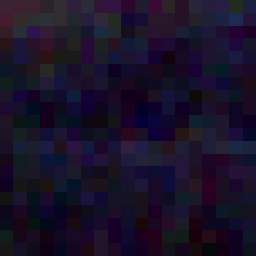

Filename: 782378908_segment_7
OSM ID: 782378908
Surface Group: mud/dirt
Center Lat: 6984224.826975656
Center Lon: -710539.0574932855
OpenStreetMap Link: https://www.openstreetmap.org/way/782378908
--------------------------------------------------------------------------------


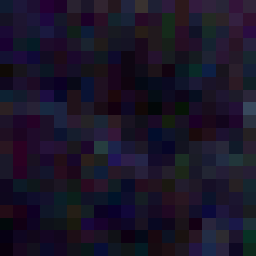

Filename: 782378908_segment_8
OSM ID: 782378908
Surface Group: mud/dirt
Center Lat: 6984190.50297958
Center Lon: -710295.0485488373
OpenStreetMap Link: https://www.openstreetmap.org/way/782378908
--------------------------------------------------------------------------------


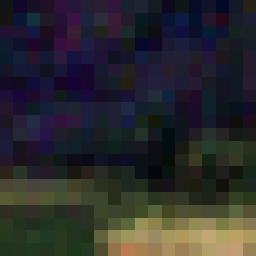

Filename: 816978050_segment_1
OSM ID: 816978050
Surface Group: gravel
Center Lat: 6983394.326390823
Center Lon: -707358.0885905032
OpenStreetMap Link: https://www.openstreetmap.org/way/816978050
--------------------------------------------------------------------------------


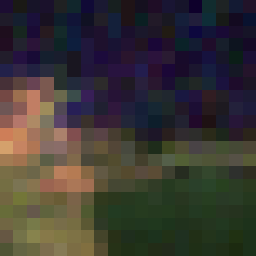

Filename: 816978050_segment_2
OSM ID: 816978050
Surface Group: gravel
Center Lat: 6983347.314559007
Center Lon: -707668.3299477061
OpenStreetMap Link: https://www.openstreetmap.org/way/816978050
--------------------------------------------------------------------------------


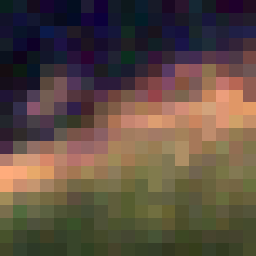

Filename: 816978050_segment_3
OSM ID: 816978050
Surface Group: gravel
Center Lat: 6983300.019336797
Center Lon: -707980.8361803677
OpenStreetMap Link: https://www.openstreetmap.org/way/816978050
--------------------------------------------------------------------------------


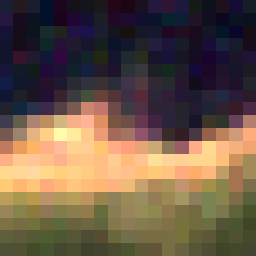

Filename: 816978050_segment_4
OSM ID: 816978050
Surface Group: gravel
Center Lat: 6983257.125770497
Center Lon: -708279.4135248162
OpenStreetMap Link: https://www.openstreetmap.org/way/816978050
--------------------------------------------------------------------------------


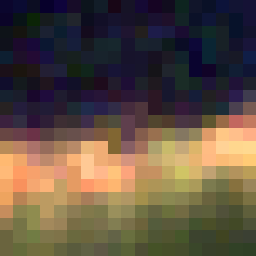

Filename: 816978050_segment_5
OSM ID: 816978050
Surface Group: gravel
Center Lat: 6983225.631841171
Center Lon: -708579.7793487569
OpenStreetMap Link: https://www.openstreetmap.org/way/816978050
--------------------------------------------------------------------------------


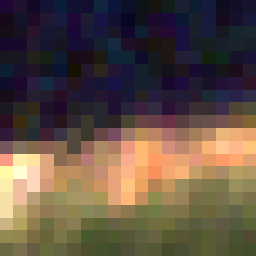

Filename: 816978050_segment_6
OSM ID: 816978050
Surface Group: gravel
Center Lat: 6983200.424012867
Center Lon: -708741.6978395364
OpenStreetMap Link: https://www.openstreetmap.org/way/816978050
--------------------------------------------------------------------------------


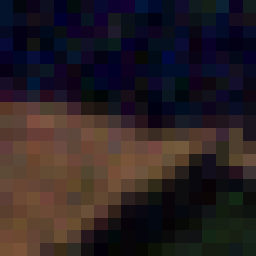

Filename: 1088208454_segment_1
OSM ID: 1088208454
Surface Group: wood
Center Lat: 6983074.899944958
Center Lon: -709601.5790243319
OpenStreetMap Link: https://www.openstreetmap.org/way/1088208454
--------------------------------------------------------------------------------


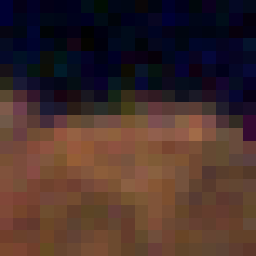

Filename: 1088208454_segment_2
OSM ID: 1088208454
Surface Group: wood
Center Lat: 6983119.789800753
Center Lon: -709911.9138084656
OpenStreetMap Link: https://www.openstreetmap.org/way/1088208454
--------------------------------------------------------------------------------


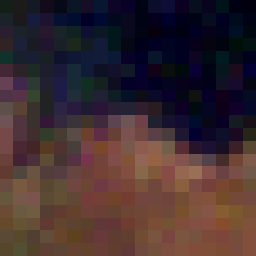

Filename: 1088208454_segment_3
OSM ID: 1088208454
Surface Group: wood
Center Lat: 6983191.245983085
Center Lon: -710215.2059460898
OpenStreetMap Link: https://www.openstreetmap.org/way/1088208454
--------------------------------------------------------------------------------


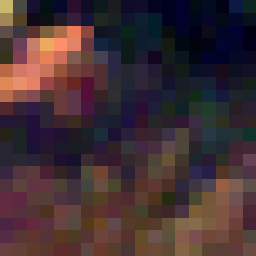

Filename: 1088208454_segment_4
OSM ID: 1088208454
Surface Group: wood
Center Lat: 6983284.277260705
Center Lon: -710515.4486989134
OpenStreetMap Link: https://www.openstreetmap.org/way/1088208454
--------------------------------------------------------------------------------


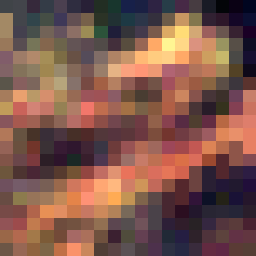

Filename: 1088208454_segment_5
OSM ID: 1088208454
Surface Group: wood
Center Lat: 6983350.488461334
Center Lon: -710778.590124306
OpenStreetMap Link: https://www.openstreetmap.org/way/1088208454
--------------------------------------------------------------------------------


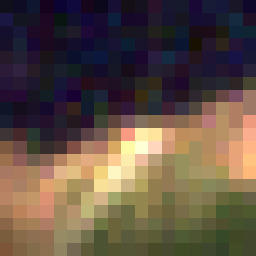

Filename: 1324047897_segment_1
OSM ID: 1324047897
Surface Group: gravel
Center Lat: 6983166.569399074
Center Lon: -708896.0166498504
OpenStreetMap Link: https://www.openstreetmap.org/way/1324047897
--------------------------------------------------------------------------------


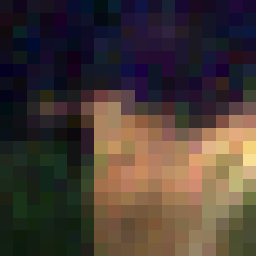

Filename: 1324047897_segment_2
OSM ID: 1324047897
Surface Group: gravel
Center Lat: 6983129.241091698
Center Lon: -709081.2634144796
OpenStreetMap Link: https://www.openstreetmap.org/way/1324047897
--------------------------------------------------------------------------------


In [4]:
import io
from PIL import Image
from IPython.display import Image as IPythonImage, display
from sqlalchemy import text

# Query both unmasked and masked images from the database
with engine.begin() as conn:
    result = conn.execute(
        text("SELECT id, filename, osm_id, surface_group, ST_X(center_geom) AS center_lon, ST_Y(center_geom) AS center_lat, image_data FROM trail_segment_metadata")
    )
    rows = result.mappings().all()

for row in rows:
    # Retrieve unmasked image
    image_bytes = row['image_data']
    buffer = io.BytesIO(image_bytes)
    unmasked_img = Image.open(buffer)
    
    # Resize image for display (256x256 pixels each)
    unmasked_resized = unmasked_img.resize((256, 256), Image.NEAREST)
    
    # Display the combined image
    display(unmasked_resized)
    
    # Print metadata
    print(f"Filename: {row['filename']}")
    print(f"OSM ID: {row['osm_id']}")
    print(f"Surface Group: {row['surface_group']}")
    print(f"Center Lat: {row['center_lat']}")
    print(f"Center Lon: {row['center_lon']}")
    zoom_level = 19
    google_maps_url = f"https://www.openstreetmap.org/way/{row['osm_id']}"
    print("OpenStreetMap Link:", google_maps_url)
    print("-" * 80)
